# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [13]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'l2':(1e-5)*(1e-6)}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [14]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [15]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


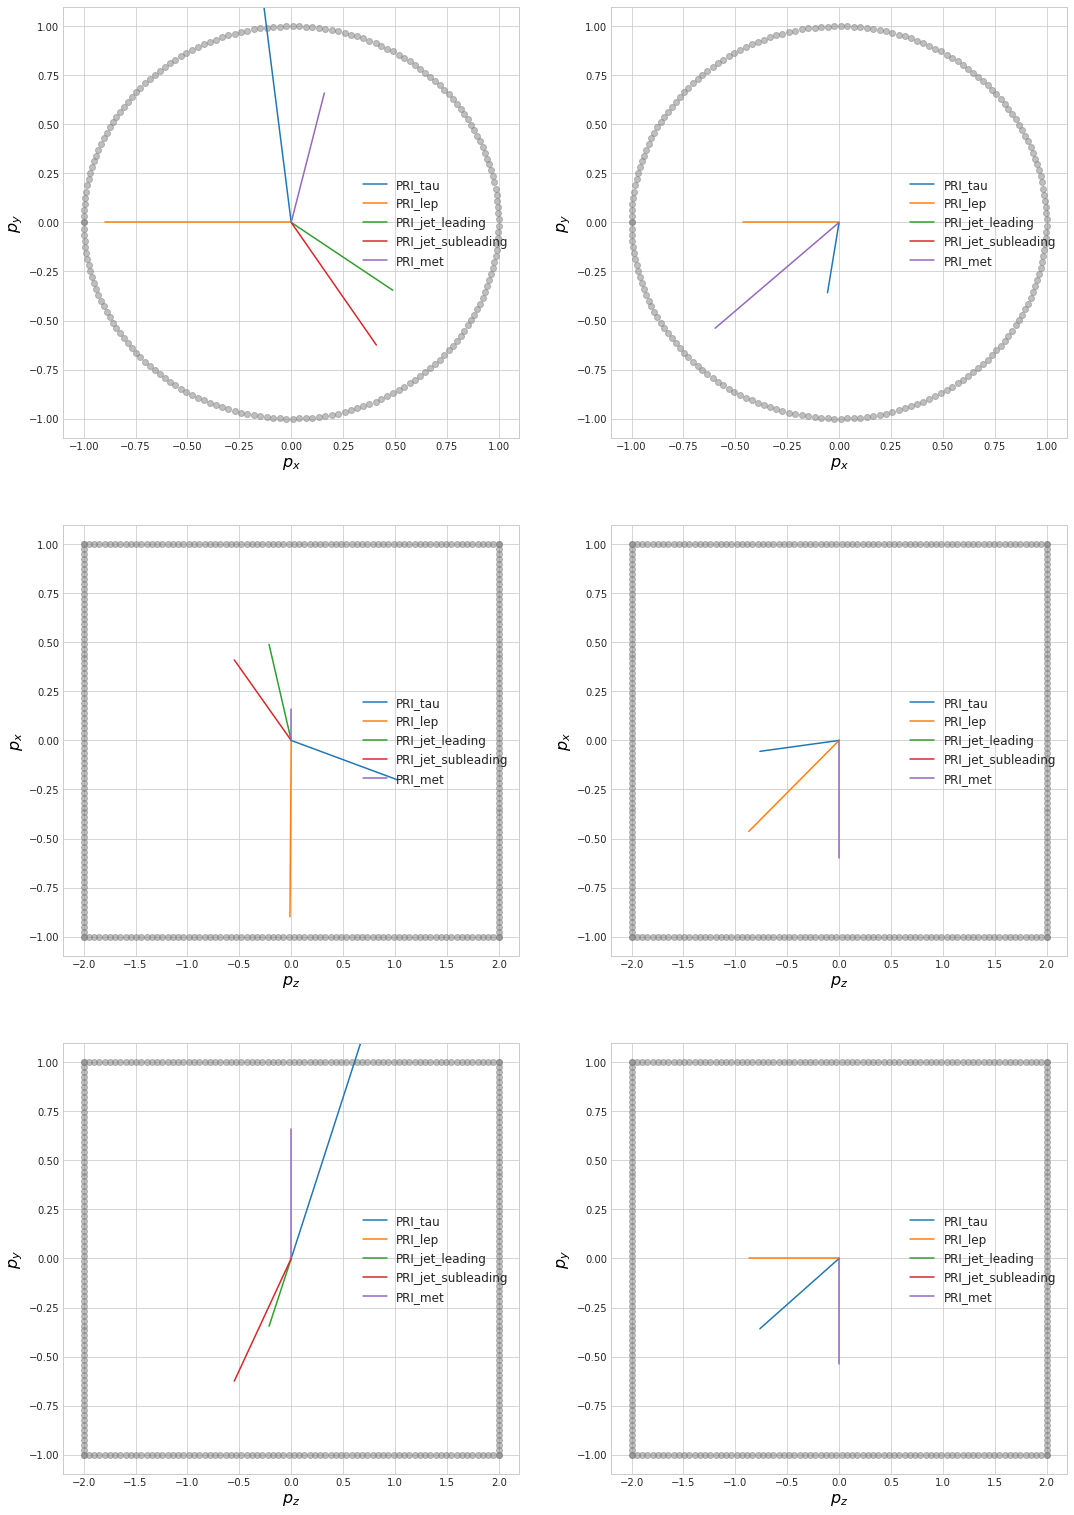

In [16]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 25.890s 


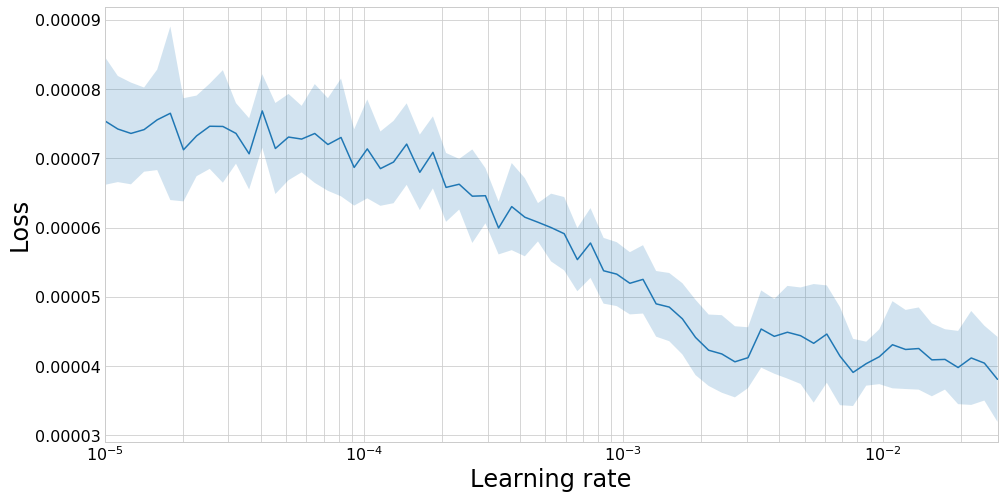

______________________________________



In [17]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

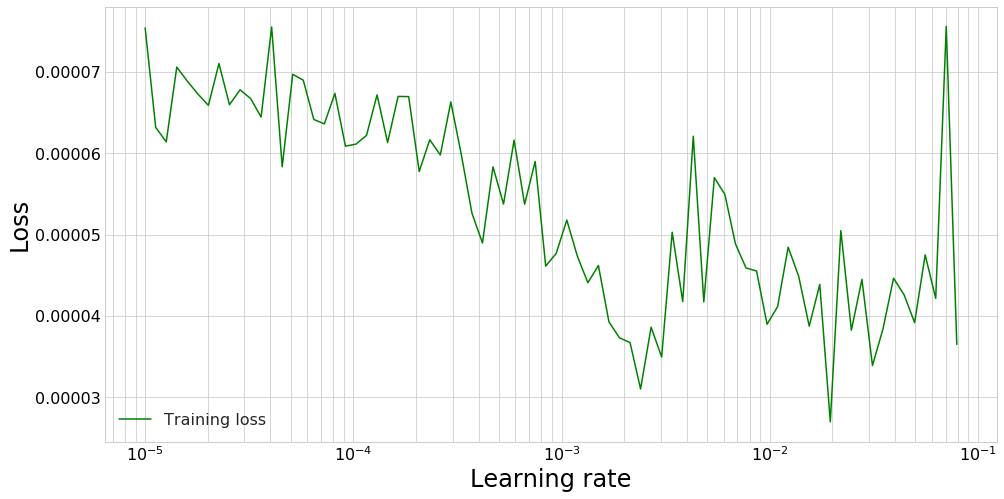

In [18]:
lr_finder[0].plot()

## Train classifier

In [19]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':8e-4}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [20]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'l2': 1.0000000000000001e-11,
  'lr': 0.0008,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.521338). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.261093). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0457816293928776e-05
2 New best found: 3.6376244138227774e-05
3 New best found: 3.587645571824396e-05
4 New best found: 3.521628705930198e-05
5 New best found: 3.474383982247673e-05
6 New best found: 3.437131215323461e-05
7 New best found: 3.429625449643936e-05
9 New best found: 3.3870253572240475e-05
10 New best found: 3.3552636894455645e-05
11 New best found: 3.345982056780485e-05
12 New best found: 3.325807874498423e-05
13 New best found: 3.320597802812699e-05
14 New best found: 3.306277155643329e-05
15 New best found: 3.30608522737748e-05
20 New best found: 3.2871933706337586e-05
23 New best found: 3.264450610877247e-05
25 New best found: 3.2573914145177695e-05
26 New best found: 3.255156369268661e-05
27 New best found: 3.249941898393445e-05
29 New best found: 3.249854534660699e-05
30 New best found: 3.247997792932438e-05
31 New best found: 3.2478061877191064e-05
47 New best found: 3.230703698791331e-05
50 New best found: 3.228898891247809e-05
53 New best found:

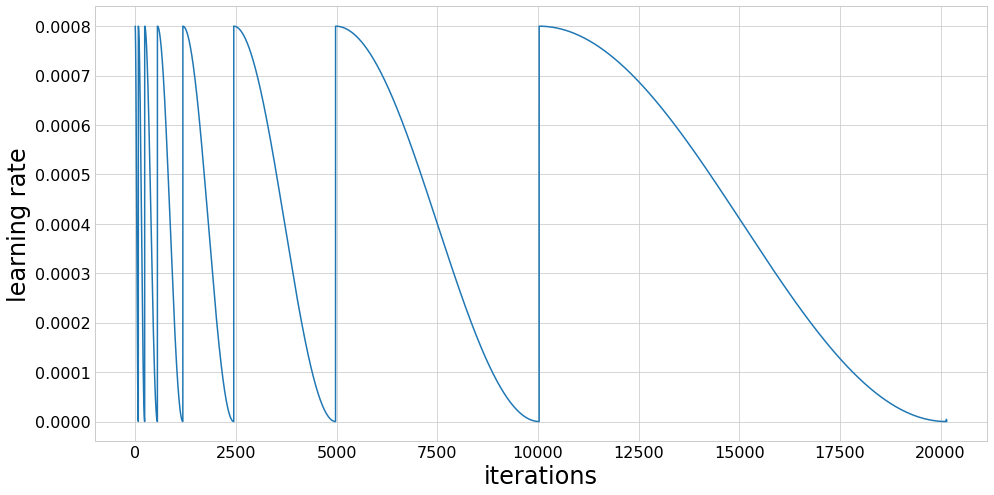

Fold took 257.464s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.597026). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.298929). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8122273524867624e-05
2 New best found: 3.4785919911363386e-05
3 New best found: 3.416139734919823e-05
4 New best found: 3.331088630244171e-05
5 New best found: 3.284038229693597e-05
6 New best found: 3.249611945333542e-05
7 New best found: 3.2447390480814434e-05
10 New best found: 3.1639160677829826e-05
12 New best found: 3.1593760547407917e-05
13 New best found: 3.1560350658922915e-05
14 New best found: 3.1526124355863974e-05
15 New best found: 3.150613394952308e-05
17 New best found: 3.1503422073961474e-05
19 New best found: 3.1469746479516404e-05
21 New best found: 3.1440325952464e-05
22 New best found: 3.121760852611415e-05
24 New best found: 3.115623212327149e-05
26 New best found: 3.0946564608365105e-05
27 New best found: 3.09121524709971e-05
28 New best found: 3.089725715774369e-05
29 New best found: 3.087452486383473e-05
30 New best found: 3.086448511165756e-05
31 New best found: 3.086210916372314e-05
45 New best found: 3.084449122503635e-05
46 New best foun

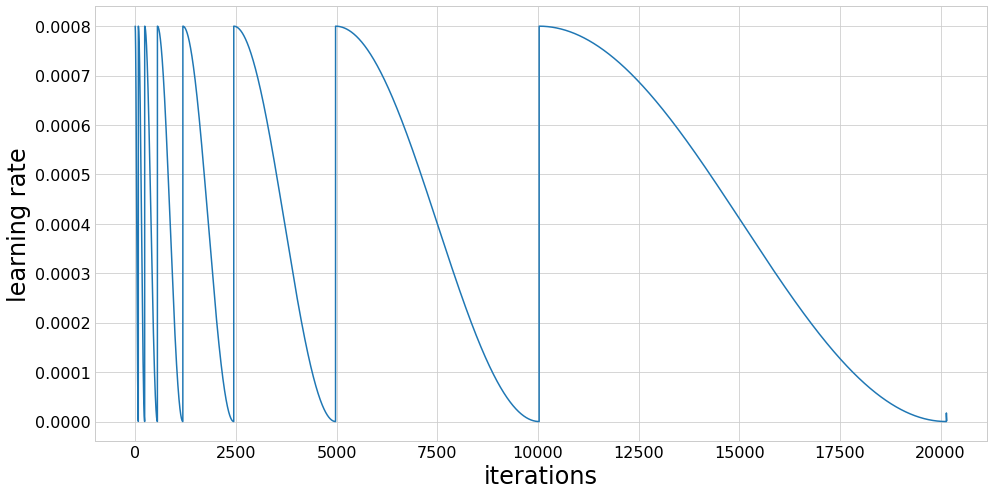

Fold took 260.942s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.631077). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.315992). Check your callbacks.
  % delta_t_median)


1 New best found: 4.012021140647222e-05
2 New best found: 3.579715636695559e-05
3 New best found: 3.511740009006354e-05
4 New best found: 3.440386796232201e-05
5 New best found: 3.366302134051648e-05
6 New best found: 3.34049880976108e-05
7 New best found: 3.3320169501066895e-05
8 New best found: 3.3275877108453876e-05
9 New best found: 3.3161349156807345e-05
10 New best found: 3.256660746354025e-05
11 New best found: 3.2344793317513475e-05
12 New best found: 3.211351596365652e-05
14 New best found: 3.200604462973522e-05
15 New best found: 3.198838185707271e-05
19 New best found: 3.185893648965789e-05
21 New best found: 3.17540064278226e-05
23 New best found: 3.161593062474571e-05
24 New best found: 3.1440801409314016e-05
25 New best found: 3.143585617060074e-05
28 New best found: 3.135178240696896e-05
29 New best found: 3.126520568535833e-05
30 New best found: 3.1253613200584555e-05
31 New best found: 3.1249707238315436e-05
42 New best found: 3.1239891955667905e-05
43 New best found: 

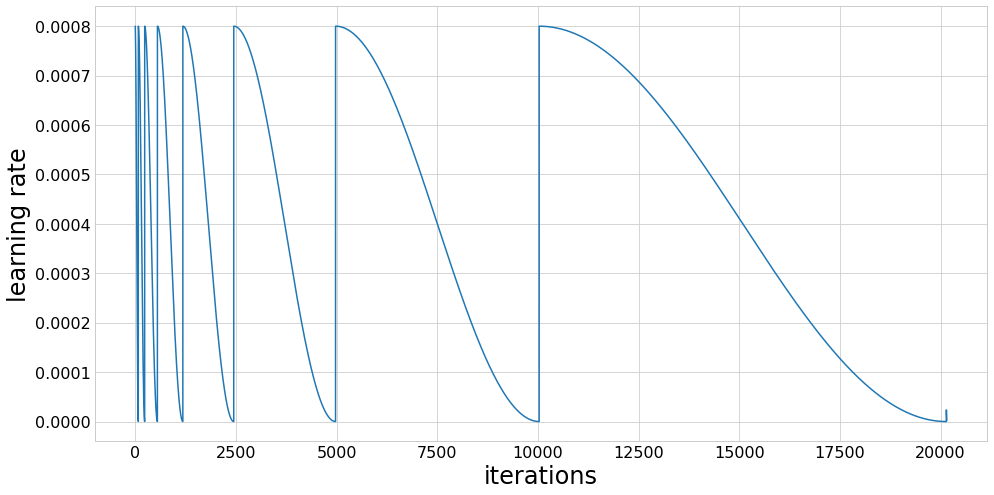

Fold took 269.350s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.655475). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.328103). Check your callbacks.
  % delta_t_median)


1 New best found: 3.989171261503386e-05
2 New best found: 3.5915395786389486e-05
3 New best found: 3.5368351317556905e-05
4 New best found: 3.4920542591353755e-05
5 New best found: 3.391709801653805e-05
6 New best found: 3.3708062701571626e-05
7 New best found: 3.369062987124878e-05
8 New best found: 3.3660697002153354e-05
9 New best found: 3.364465439022003e-05
10 New best found: 3.3327669114272894e-05
11 New best found: 3.295688897351207e-05
12 New best found: 3.28268666894955e-05
13 New best found: 3.272122983281969e-05
15 New best found: 3.26966680299932e-05
20 New best found: 3.239543314662994e-05
24 New best found: 3.22915508625842e-05
26 New best found: 3.228314601747019e-05
27 New best found: 3.219967326374835e-05
28 New best found: 3.2175805742929926e-05
29 New best found: 3.2159971933619316e-05
30 New best found: 3.215881765923646e-05
31 New best found: 3.2157074159578486e-05
46 New best found: 3.213553629309983e-05
47 New best found: 3.2038362359564054e-05
48 New best found:

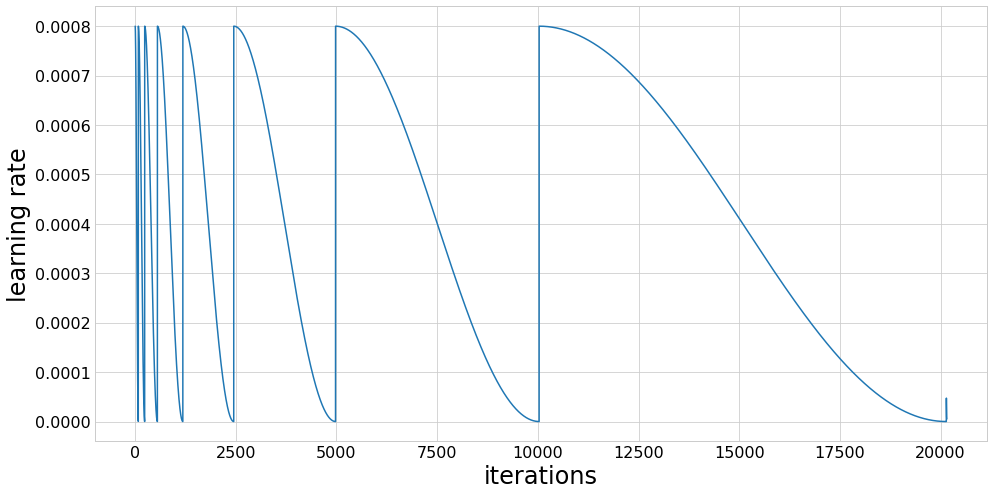

Fold took 277.186s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.615252). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.308022). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9559896614809984e-05
2 New best found: 3.535126846691128e-05
3 New best found: 3.490670147293713e-05
4 New best found: 3.428303953551222e-05
5 New best found: 3.347392465220764e-05
6 New best found: 3.3228235079150185e-05
7 New best found: 3.316779286105884e-05
9 New best found: 3.276295264222426e-05
10 New best found: 3.269528732344043e-05
11 New best found: 3.2688486797269435e-05
12 New best found: 3.240943814162165e-05
13 New best found: 3.227748699864606e-05
14 New best found: 3.216889412578894e-05
15 New best found: 3.2155815056466966e-05
19 New best found: 3.199554468737915e-05
21 New best found: 3.1897374676191246e-05
23 New best found: 3.177958948654123e-05
26 New best found: 3.1718179090239576e-05
27 New best found: 3.1575359794078396e-05
28 New best found: 3.1572826279443686e-05
29 New best found: 3.1538073442061435e-05
50 New best found: 3.1457774400769266e-05
54 New best found: 3.1352646400046066e-05
56 New best found: 3.133582061418565e-05
99 New best f

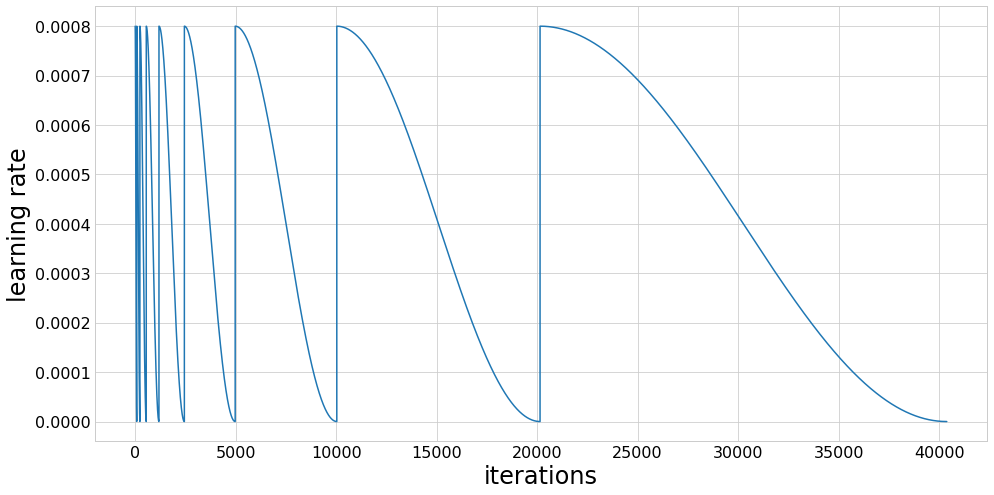

Fold took 549.124s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.746772). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.373882). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9467670909652954e-05
2 New best found: 3.679051716171671e-05
3 New best found: 3.628155561600579e-05
4 New best found: 3.5612385671993254e-05
5 New best found: 3.499906372308033e-05
6 New best found: 3.483971411187668e-05
7 New best found: 3.472573699837085e-05
10 New best found: 3.427102376590483e-05
11 New best found: 3.418281438498525e-05
12 New best found: 3.393225196778076e-05
13 New best found: 3.385499044525204e-05
14 New best found: 3.376314546767389e-05
15 New best found: 3.3756982164049987e-05
22 New best found: 3.373034602991538e-05
23 New best found: 3.342141350294696e-05
24 New best found: 3.334546269761631e-05
25 New best found: 3.3332345956296195e-05
26 New best found: 3.323724381189095e-05
27 New best found: 3.322799938032403e-05
35 New best found: 3.319545163976727e-05
44 New best found: 3.3083520762738774e-05
48 New best found: 3.3034506377589426e-05
50 New best found: 3.292438691714779e-05
59 New best found: 3.2900999757112004e-05
61 New best foun

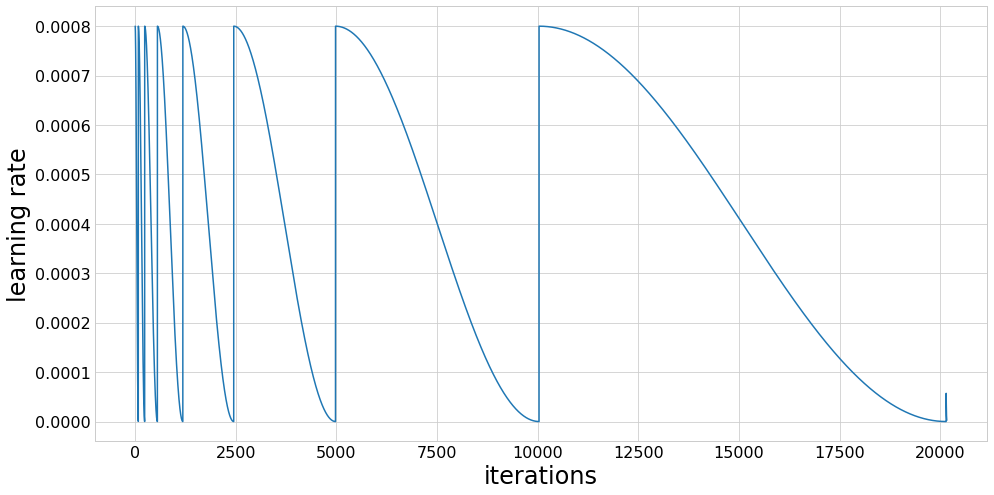

Fold took 290.735s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.756394). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.378651). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0073606010092816e-05
2 New best found: 3.654597828644572e-05
3 New best found: 3.6055829314337634e-05
4 New best found: 3.5168128569499034e-05
5 New best found: 3.457083778675367e-05
6 New best found: 3.4184883547052135e-05
7 New best found: 3.415574599349042e-05
8 New best found: 3.4008153145267786e-05
10 New best found: 3.363787495606412e-05
11 New best found: 3.353675721270914e-05
12 New best found: 3.350727277956884e-05
13 New best found: 3.339439615706955e-05
14 New best found: 3.3332639488039534e-05
15 New best found: 3.3306964186230805e-05
18 New best found: 3.317112815634053e-05
22 New best found: 3.3136742722402694e-05
23 New best found: 3.281105242687486e-05
24 New best found: 3.2752828034642034e-05
26 New best found: 3.27173428124819e-05
28 New best found: 3.269470977877206e-05
30 New best found: 3.2692203341788995e-05
31 New best found: 3.2689607145077234e-05
44 New best found: 3.259827967287739e-05
50 New best found: 3.25188817725288e-05
53 New best fou

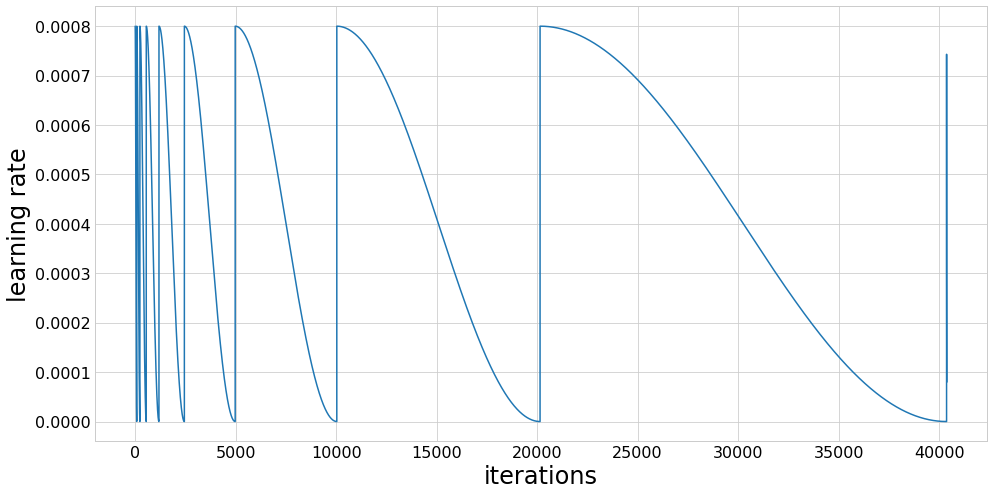

Fold took 561.600s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.805036). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.402983). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0965303735256034e-05
2 New best found: 3.661494966549561e-05
3 New best found: 3.6197984191336236e-05
4 New best found: 3.525500454668128e-05
5 New best found: 3.489995236943464e-05
6 New best found: 3.47911468782757e-05
7 New best found: 3.465161473374433e-05
9 New best found: 3.428349701464906e-05
10 New best found: 3.414519668589441e-05
11 New best found: 3.4035856014518196e-05
12 New best found: 3.382203841649762e-05
13 New best found: 3.3697464887448876e-05
14 New best found: 3.366840784246558e-05
15 New best found: 3.366072214636912e-05
17 New best found: 3.357242709580371e-05
22 New best found: 3.344804921985286e-05
25 New best found: 3.3283144055662804e-05
26 New best found: 3.3232412857903744e-05
30 New best found: 3.318284985726954e-05
31 New best found: 3.317833569034891e-05
40 New best found: 3.304610529103321e-05
47 New best found: 3.3031727700140065e-05
49 New best found: 3.2911371848150935e-05
53 New best found: 3.2812794220207474e-05
58 New best foun

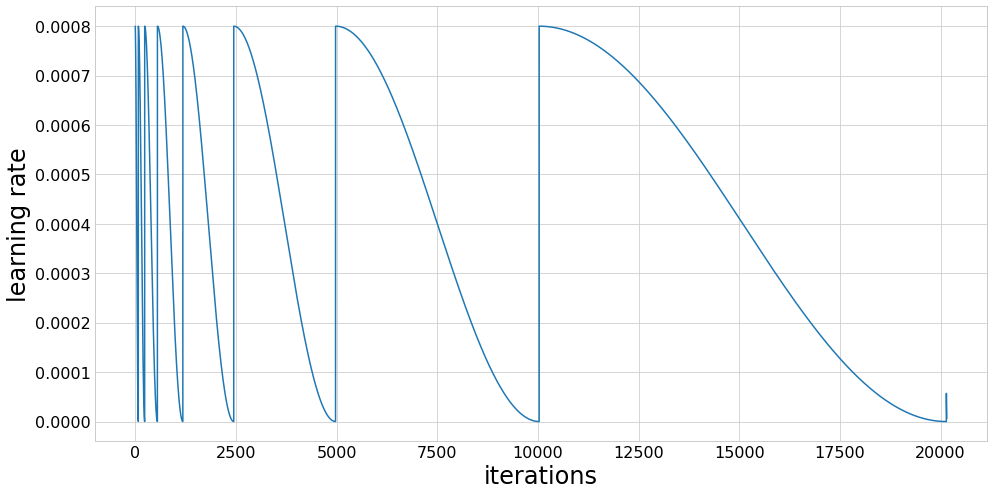

Fold took 290.851s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.872261). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.436553). Check your callbacks.
  % delta_t_median)


1 New best found: 3.899097687028403e-05
2 New best found: 3.6378205050980396e-05
3 New best found: 3.5713431776344166e-05
4 New best found: 3.4657925869236704e-05
5 New best found: 3.433688663599777e-05
6 New best found: 3.400208413726784e-05
7 New best found: 3.391801841260693e-05
9 New best found: 3.3566710721822564e-05
11 New best found: 3.301177141904776e-05
12 New best found: 3.2939170925303267e-05
13 New best found: 3.285675656270049e-05
14 New best found: 3.2770903571760294e-05
18 New best found: 3.267695829761617e-05
21 New best found: 3.2578398732231124e-05
22 New best found: 3.248592772830654e-05
23 New best found: 3.2443325028412456e-05
25 New best found: 3.2273301308580605e-05
26 New best found: 3.216558652604361e-05
27 New best found: 3.216362532912357e-05
28 New best found: 3.21540707801752e-05
29 New best found: 3.211005503666826e-05
31 New best found: 3.2109339809561823e-05
43 New best found: 3.203730038077498e-05
44 New best found: 3.197546645847863e-05
52 New best fou

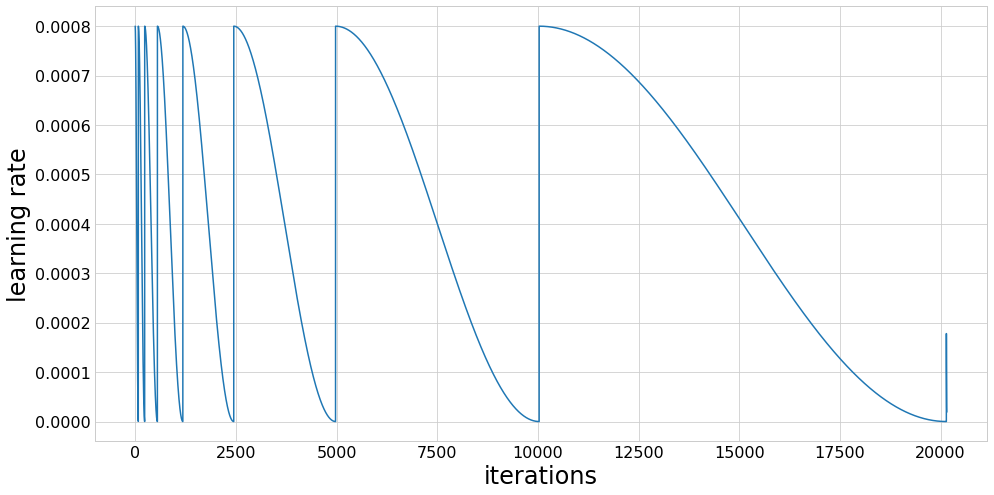

Fold took 295.018s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.838946). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.419902). Check your callbacks.
  % delta_t_median)


1 New best found: 4.041660451039206e-05
2 New best found: 3.671526550606359e-05
3 New best found: 3.603784384904429e-05
4 New best found: 3.519364809326362e-05
5 New best found: 3.46999106448493e-05
6 New best found: 3.4478667950315864e-05
7 New best found: 3.4427242862875577e-05
10 New best found: 3.371271319920197e-05
11 New best found: 3.355797113181325e-05
12 New best found: 3.3529471448855477e-05
13 New best found: 3.349048356176354e-05
14 New best found: 3.3339146067737604e-05
15 New best found: 3.332209115615115e-05
17 New best found: 3.3316876404569485e-05
18 New best found: 3.325865596125368e-05
20 New best found: 3.320329234993551e-05
22 New best found: 3.31018200260587e-05
23 New best found: 3.304504820407601e-05
24 New best found: 3.279675982776098e-05
26 New best found: 3.263778382679448e-05
28 New best found: 3.2618371458374895e-05
42 New best found: 3.2594346975383816e-05
44 New best found: 3.24756060144864e-05
50 New best found: 3.239452109119156e-05
53 New best found: 

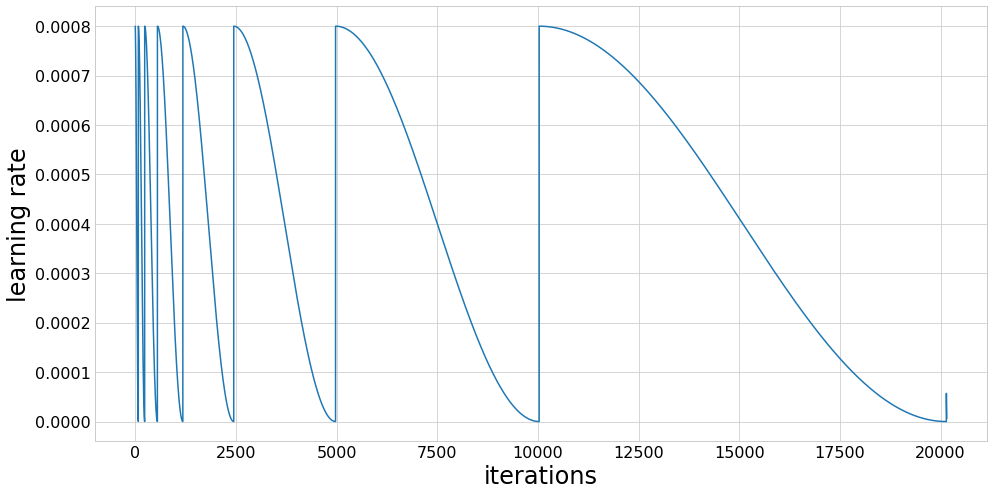

Fold took 303.371s


______________________________________
Training finished
Cross-validation took 3361.534s 


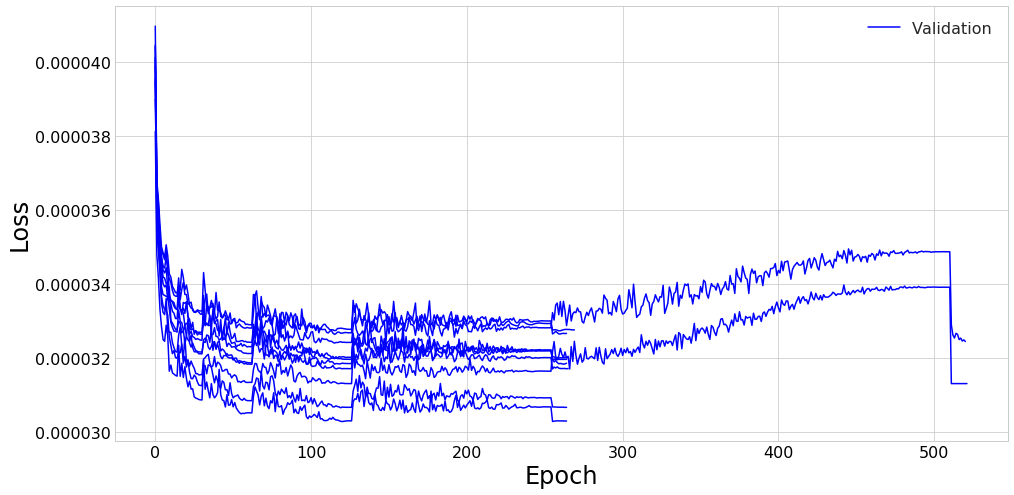

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.0631 +- 0.001
Mean AUC = 0.0988 +- 0.0009
Mean AMS = 3.82 +- 0.07
Mean cut = 0.957 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [21]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [22]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [23]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 1 with loss = 3.027899130397527e-05
Model 1 is 2 with loss = 3.065060027735868e-05
Model 2 is 4 with loss = 3.1304224181803875e-05
Model 3 is 3 with loss = 3.1699764212363593e-05
Model 4 is 8 with loss = 3.17932327516744e-05
Model 5 is 0 with loss = 3.19585654506227e-05
Model 6 is 9 with loss = 3.198135594575433e-05
Model 7 is 6 with loss = 3.2394716690774654e-05
Model 8 is 7 with loss = 3.263609471017021e-05
Model 9 is 5 with loss = 3.273174397327239e-05


## Response on validation data without TTA

In [24]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [25]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00284544776622206s per sample

Predicting fold 2 out of 10
Prediction took 0.00041842068564146756s per sample

Predicting fold 3 out of 10
Prediction took 0.000421069429628551s per sample

Predicting fold 4 out of 10
Prediction took 0.00041628632228821514s per sample

Predicting fold 5 out of 10
Prediction took 0.0004174088530242443s per sample

Predicting fold 6 out of 10
Prediction took 0.00041688836868852375s per sample

Predicting fold 7 out of 10
Prediction took 0.0004170780550688505s per sample

Predicting fold 8 out of 10
Prediction took 0.0004195427006110549s per sample

Predicting fold 9 out of 10
Prediction took 0.00041734577026218174s per sample

Predicting fold 10 out of 10
Prediction took 0.0004173376936465502s per sample



In [26]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [27]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9036630609830807, weighted 0.9359279617858556


Best cut at 0.962528939003701 corresponds to AMS of 3.8522513560450546
Maximum AMS for data is 3.9146724701224684 at cut of 0.9635494351387024
CPU times: user 25.8 s, sys: 0 ns, total: 25.8 s
Wall time: 25.8 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


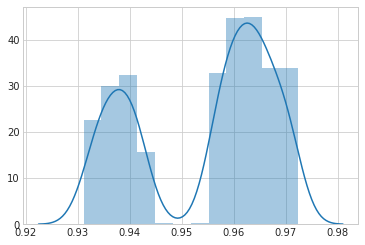

In [28]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9544912 corresponds to AMS of 3.750087582600239
Maximum AMS for data is 3.9146724701224684 at cut of 0.9635494351387024
CPU times: user 105 ms, sys: 72.5 ms, total: 178 ms
Wall time: 79.9 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


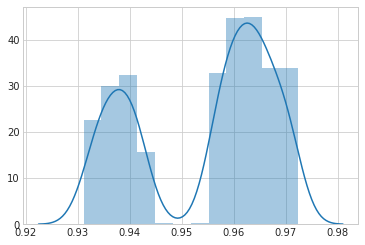

In [29]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [30]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [31]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.000413897644830021s per sample

Predicting fold 2 out of 10
Prediction took 0.0004129392782734199s per sample

Predicting fold 3 out of 10
Prediction took 0.0004127225486053662s per sample

Predicting fold 4 out of 10
Prediction took 0.00041317509439858525s per sample

Predicting fold 5 out of 10
Prediction took 0.0004151846566830169s per sample

Predicting fold 6 out of 10
Prediction took 0.00041401922782375054s per sample

Predicting fold 7 out of 10
Prediction took 0.0004124862350523472s per sample

Predicting fold 8 out of 10
Prediction took 0.0004147884689779444s per sample

Predicting fold 9 out of 10
Prediction took 0.00041543083883483303s per sample

Predicting fold 10 out of 10
Prediction took 0.0004156313877383416s per sample

CPU times: user 4min 2s, sys: 11.3 s, total: 4min 13s
Wall time: 3min 47s


In [32]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.611764979654836 : 3.7164847141615693


(3.611764979654836, 3.7164847141615693)

In [33]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.754978688401834 : 3.745665292767188


(3.754978688401834, 3.745665292767188)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)